In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.cluster import vq
from scipy.spatial.distance import euclidean as d_eucli

def reconstruction_error(orig, reconstructed):
    return d_eucli(orig, reconstructed)

def list_reconstruction_error(list_orig, list_reconstruct):
    errors = []
    for i in range(len(list_orig)):
        errors.append(reconstruction_error(list_orig[i], list_reconstruct[i]))
    return errors

# define basic functions and encoder

In [2]:
def kmeans(vs, ks, niter):
    centers, labels = vq.kmeans2(vs, ks, niter)
    return centers


def pq_kmeans_assign(centroids, query):
    
    dist = euclidean(centroids, query)
    return dist.argmin(1)

def euclidean(feat, query, featl2norm=None, qryl2norm=None):

    dotprod = query.dot(feat.T)

    if qryl2norm is None:
        qryl2norm = (query ** 2).sum(1).reshape(-1, 1)
    if featl2norm is None:
        featl2norm = (feat ** 2).sum(1).reshape(1, -1)

    return - 2 * dotprod + qryl2norm + featl2norm


In [3]:
class PQEncoder():
    """
    Product Quantization Encoder
    """
    def __init__(self):
        super(PQEncoder, self).__init__()

    def __del__(self):
        pass

    def build(self, pardic=None):
        # training data
        vals = pardic['vals']
        # the number of subquantizers
        nsubq = pardic['nsubq']
        # the number bits of each subquantizer
        nsubqbits = pardic.get('nsubqbits', 8)

        # vector dimension
        self.dim = vals.shape[1]
        dim = vals.shape[1]

        # dimension of the subvectors to quantize
        dsub = dim / nsubq
        # number of centroids per subquantizer
        ksub = 2 ** nsubqbits

        """
        Initializing indexer data
        """
        ecdat = dict()
        ecdat['nsubq'] = nsubq
        ecdat['ksub'] = ksub
        ecdat['dsub'] = dsub
        ecdat['centroids'] = [None for q in range(nsubq)]

        for q in range(nsubq):
            vs = np.require(vals[:, int(q*dsub):int((q+1)*dsub)],
                            requirements='C', dtype=np.float32)
            ecdat['centroids'][q] = kmeans(vs, ksub, niter=100)

        self.ecdat = ecdat

    def encode(self, vals):
        dsub = self.ecdat['dsub']
        nsubq = self.ecdat['nsubq']
        centroids = self.ecdat['centroids']

        num_vals = vals.shape[0]
        codes = np.zeros((num_vals, nsubq), np.uint8)
        for q in range(nsubq):
            vsub = vals[:, int(q*dsub):int((q+1)*dsub)]
            codes[:, q] = pq_kmeans_assign(centroids[q], vsub)
        return codes
    
    def decode(self, codes):
        centroids = self.ecdat['centroids']
        dsub = self.ecdat['dsub']
        decodes = np.zeros((codes.shape[0],self.dim))
        i = 0
        for centroid in centroids:
            j=0
            for  decode in decodes:

                decode[int(i*dsub):int((i + 1)*dsub)] = centroid[codes[j][i]]
                j+=1
                
            i+=1
        
        return decodes


# Build encoder on different settings

In [4]:
np.random.seed(0)

time_series50k_seismic = np.fromfile("seismic_size50k_len256_znorm.bin", dtype=np.float32).reshape(-1, 256)

encoder32b_seismic = PQEncoder()

encoder64b_seismic = PQEncoder()

encoder128b_seismic = PQEncoder()

encoder32b_seismic.build({'vals': time_series50k_seismic, 'nsubq': 32, 'nsubqbits': 7})
encoder64b_seismic.build({'vals': time_series50k_seismic, 'nsubq': 64, 'nsubqbits': 6 })
encoder128b_seismic.build({'vals': time_series50k_seismic, 'nsubq': 128, 'nsubqbits': 5})

In [5]:
np.random.seed(0)

time_series50k_synthetic = np.fromfile("synthetic_size50k_len256_znorm.bin", dtype=np.float32).reshape(-1, 256)

encoder32b_synthetic = PQEncoder()

encoder64b_synthetic = PQEncoder()

encoder128b_synthetic = PQEncoder()

encoder32b_synthetic.build({'vals': time_series50k_synthetic, 'nsubq': 32, 'nsubqbits': 7})
encoder64b_synthetic.build({'vals': time_series50k_synthetic, 'nsubq': 64, 'nsubqbits': 6 })
encoder128b_synthetic.build({'vals': time_series50k_synthetic, 'nsubq': 128, 'nsubqbits': 5})

C:\Users\user\anaconda3\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


# Encode

In [6]:
reduced_ts_32b_seismic = encoder32b_seismic.encode(time_series50k_seismic)
reduced_ts_64b_seismic = encoder64b_seismic.encode(time_series50k_seismic)
reduced_ts_128b_seismic = encoder128b_seismic.encode(time_series50k_seismic)

In [7]:
reduced_ts_32b_synthetic = encoder32b_synthetic.encode(time_series50k_synthetic)
reduced_ts_64b_synthetic = encoder64b_synthetic.encode(time_series50k_synthetic)
reduced_ts_128b_synthetic = encoder128b_synthetic.encode(time_series50k_synthetic)

# Decode

In [8]:
decoded_ts_32b_seismic = encoder32b_seismic.decode(reduced_ts_32b_seismic)
decoded_ts_64b_seismic = encoder64b_seismic.decode(reduced_ts_64b_seismic)
decoded_ts_128b_seismic = encoder128b_seismic.decode(reduced_ts_128b_seismic)

In [9]:
decoded_ts_32b_synthetic = encoder32b_synthetic.decode(reduced_ts_32b_synthetic)
decoded_ts_64b_synthetic = encoder64b_synthetic.decode(reduced_ts_64b_synthetic)
decoded_ts_128b_synthetic = encoder128b_synthetic.decode(reduced_ts_128b_synthetic)

# Results

In [10]:
rec_errors_32_seismic = list_reconstruction_error(time_series50k_seismic, decoded_ts_32b_seismic)
print("average loss 32Bytes seismic", np.average(rec_errors_32_seismic))
rec_errors_64_seismic = list_reconstruction_error(time_series50k_seismic, decoded_ts_64b_seismic)
print("average loss 64Bytes seismic", np.average(rec_errors_64_seismic))
rec_errors_128_seismic = list_reconstruction_error(time_series50k_seismic, decoded_ts_128b_seismic)
print("average loss 128Bytes seismic", np.average(rec_errors_128_seismic))


average loss 32Bytes seismic 7.909359936501205
average loss 64Bytes seismic 5.993455743107379
average loss 128Bytes seismic 3.794906262077649


In [11]:
rec_errors_32_synthetic = list_reconstruction_error(time_series50k_synthetic, decoded_ts_32b_synthetic)
print("average loss 32Bytes synthetic", np.average(rec_errors_32_synthetic))
rec_errors_64_synthetic = list_reconstruction_error(time_series50k_synthetic, decoded_ts_64b_synthetic)
print("average loss 64Bytes synthetic", np.average(rec_errors_64_synthetic))
rec_errors_128_synthetic = list_reconstruction_error(time_series50k_synthetic, decoded_ts_128b_synthetic)
print("average loss 128Bytes synthetic", np.average(rec_errors_128_synthetic))


average loss 32Bytes synthetic 2.3526222921072053
average loss 64Bytes synthetic 1.9117367482896408
average loss 128Bytes synthetic 1.560543121813532


# Graphical result

In [29]:
import matplotlib.pyplot as plt
ts_length = len(time_series50k_seismic[1][:50])


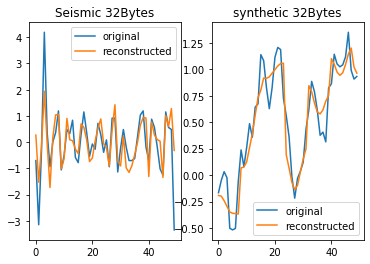

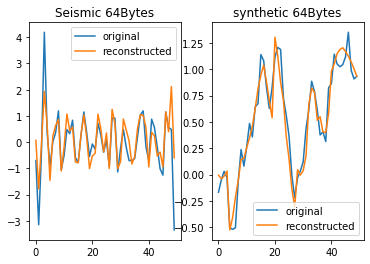

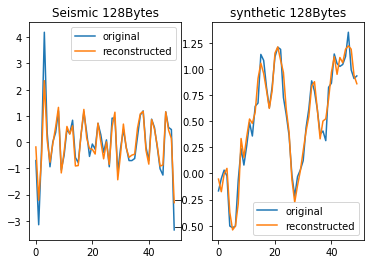

In [51]:
fig32, axs32 = plt.subplots(1, 2)


axs32[0].plot(range(ts_length), time_series50k_seismic[1][:50], label="original")
axs32[0].plot(range(ts_length), decoded_ts_32b_seismic[1][:50], label="reconstructed")
axs32[0].set_title("Seismic 32Bytes")
axs32[0].legend()

axs32[1].plot(range(ts_length), time_series50k_synthetic[1][:50], label="original")
axs32[1].plot(range(ts_length), decoded_ts_32b_synthetic[1][:50], label="reconstructed")
axs32[1].set_title("synthetic 32Bytes")
axs32[1].legend()

fig64, axs64 = plt.subplots(1, 2)


axs64[0].plot(range(ts_length), time_series50k_seismic[1][:50], label="original")
axs64[0].plot(range(ts_length), decoded_ts_64b_seismic[1][:50], label="reconstructed")
axs64[0].set_title("Seismic 64Bytes")
axs64[0].legend()

axs64[1].plot(range(ts_length), time_series50k_synthetic[1][:50], label="original")
axs64[1].plot(range(ts_length), decoded_ts_64b_synthetic[1][:50], label="reconstructed")
axs64[1].set_title("synthetic 64Bytes")
axs64[1].legend()

fig128, axs128 = plt.subplots(1, 2)


axs128[0].plot(range(ts_length), time_series50k_seismic[1][:50], label="original")
axs128[0].plot(range(ts_length), decoded_ts_128b_seismic[1][:50], label="reconstructed")
axs128[0].set_title("Seismic 128Bytes")
axs128[0].legend()

axs128[1].plot(range(ts_length), time_series50k_synthetic[1][:50], label="original")
axs128[1].plot(range(ts_length), decoded_ts_128b_synthetic[1][:50], label="reconstructed")
axs128[1].set_title("synthetic 128Bytes")
axs128[1].legend()
